## Promoter Model using a Keras Neural Network & Traditional Machine Learning Methods with Scikit-Learn

For gene expression to happen in a cell, proteins (RNA polymerase, sigma factors, etc.,) interact with portions of DNA sequence to initiate and otherwise control various aspects of this process. These stretches of DNA are promoters, and in bacterial systems such as *E. coli*, promoters are marked by the presence of -35 and -10 elements, defined as DNA hexamers that are located -35 and -10 nucleotides, respectively, upstream from the transcriptional start site<sup>1</sup>.

The following short project evalutes techniques to predict whether a given nucleotide position and its identity are predictive of the sequence belonging to a bacterial promoter or not. The data set comes from the University of California, Irvine, Machine Learning Repository<sup>2</sup>, with development described in a separate report<sup>3</sup>.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import EarlyStopping

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import SVC
from xgboost import (XGBClassifier, plot_importance, DMatrix)
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

import shap
import lime
import lime.lime_tabular

Using TensorFlow backend.


In [2]:
pro_df = pd.read_csv("promoters.data.txt", delimiter=',', header=None)
pro_df.columns = ['status', 'name', 'seq']
pro_df.head()

status       name                                                seq
0      +        S10  \t\ttactagcaatacgcttgcgttcggtggttaagtatgtataat...
1      +       AMPC  \t\ttgctatcctgacagttgtcacgctgattggtgtcgttacaat...
2      +       AROH  \t\tgtactagagaactagtgcattagcttatttttttgttatcat...
3      +      DEOP2  \taattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaa...
4      +  LEU1_TRNA  \ttcgataattaactattgacgaaaagctgaaaaccactagaatgc...

In [3]:
pro_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 3 columns):
status    106 non-null object
name      106 non-null object
seq       106 non-null object
dtypes: object(3)
memory usage: 2.6+ KB


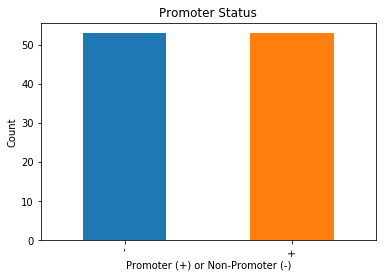

In [4]:
pro_df['status'].value_counts().plot(kind='bar')
plt.title('Promoter Status')
plt.xlabel('Promoter (+) or Non-Promoter (-)')
plt.ylabel('Count')
plt.show()

The target class, status of being a promoter or non-promoter sequence, is balanced in this data set. The next step is to transform the status label from a symbol into a numeric value, with "1" for a promoter and "0" for a non-promoter. 

In [5]:
def recode(value):
    if value == '+':
        return 1
    elif value == '-':
        return 0
    else:
        return value
pro_df['status'] = pro_df.status.apply(recode)

In [6]:
pro_df.head()

status       name                                                seq
0       1        S10  \t\ttactagcaatacgcttgcgttcggtggttaagtatgtataat...
1       1       AMPC  \t\ttgctatcctgacagttgtcacgctgattggtgtcgttacaat...
2       1       AROH  \t\tgtactagagaactagtgcattagcttatttttttgttatcat...
3       1      DEOP2  \taattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaa...
4       1  LEU1_TRNA  \ttcgataattaactattgacgaaaagctgaaaaccactagaatgc...

In [7]:
pro_df['seq'] = pro_df.seq.str.replace('\W', '')

In [8]:
pro_df.head()

status       name                                                seq
0       1        S10  tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...
1       1       AMPC  tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...
2       1       AROH  gtactagagaactagtgcattagcttatttttttgttatcatgcta...
3       1      DEOP2  aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...
4       1  LEU1_TRNA  tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...

In [9]:
sequence = pro_df['seq'].str.strip()

In [10]:
sequence.head()

0    tactagcaatacgcttgcgttcggtggttaagtatgtataatgcgc...
1    tgctatcctgacagttgtcacgctgattggtgtcgttacaatctaa...
2    gtactagagaactagtgcattagcttatttttttgttatcatgcta...
3    aattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaata...
4    tcgataattaactattgacgaaaagctgaaaaccactagaatgcgc...
Name: seq, dtype: object

Since each sequence entry is an unusably long sequence, next it is divided one nucleotide at a time, with each nucleotide as its own feature and maintaining its position. 

In [11]:
seqsplit = []
for n in sequence:
    seqsplit.append(list(n))

In [12]:
print(seqsplit)

[['t', 'a', 'c', 't', 'a', 'g', 'c', 'a', 'a', 't', 'a', 'c', 'g', 'c', 't', 't', 'g', 'c', 'g', 't', 't', 'c', 'g', 'g', 't', 'g', 'g', 't', 't', 'a', 'a', 'g', 't', 'a', 't', 'g', 't', 'a', 't', 'a', 'a', 't', 'g', 'c', 'g', 'c', 'g', 'g', 'g', 'c', 't', 't', 'g', 't', 'c', 'g', 't'], ['t', 'g', 'c', 't', 'a', 't', 'c', 'c', 't', 'g', 'a', 'c', 'a', 'g', 't', 't', 'g', 't', 'c', 'a', 'c', 'g', 'c', 't', 'g', 'a', 't', 't', 'g', 'g', 't', 'g', 't', 'c', 'g', 't', 't', 'a', 'c', 'a', 'a', 't', 'c', 't', 'a', 'a', 'c', 'g', 'c', 'a', 't', 'c', 'g', 'c', 'c', 'a', 'a'], ['g', 't', 'a', 'c', 't', 'a', 'g', 'a', 'g', 'a', 'a', 'c', 't', 'a', 'g', 't', 'g', 'c', 'a', 't', 't', 'a', 'g', 'c', 't', 't', 'a', 't', 't', 't', 't', 't', 't', 't', 'g', 't', 't', 'a', 't', 'c', 'a', 't', 'g', 'c', 't', 'a', 'a', 'c', 'c', 'a', 'c', 'c', 'c', 'g', 'g', 'c', 'g'], ['a', 'a', 't', 't', 'g', 't', 'g', 'a', 't', 'g', 't', 'g', 't', 'a', 't', 'c', 'g', 'a', 'a', 'g', 't', 'g', 't', 'g', 't', 't', 'g', 'c

In [13]:
seq_df = pd.DataFrame(seqsplit, columns = [str(i) for i in range(0,57)])
seq_df.head()

0  1  2  3  4  5  6  7  8  9 ... 47 48 49 50 51 52 53 54 55 56
0  t  a  c  t  a  g  c  a  a  t ...  g  g  c  t  t  g  t  c  g  t
1  t  g  c  t  a  t  c  c  t  g ...  g  c  a  t  c  g  c  c  a  a
2  g  t  a  c  t  a  g  a  g  a ...  c  c  a  c  c  c  g  g  c  g
3  a  a  t  t  g  t  g  a  t  g ...  t  a  a  c  a  a  a  c  t  c
4  t  c  g  a  t  a  a  t  t  a ...  t  c  c  g  t  g  g  t  a  g

[5 rows x 57 columns]

In [14]:
pdf = pd.concat([pro_df, seq_df], axis=1)
pdf.set_index('name', inplace=True)

In [15]:
pdf = pdf.drop('seq', axis=1)
pdf.head()

status  0  1  2  3  4  5  6  7  8 ... 47 48 49 50 51 52 53 54 55 56
name                                         ...                              
S10             1  t  a  c  t  a  g  c  a  a ...  g  g  c  t  t  g  t  c  g  t
AMPC            1  t  g  c  t  a  t  c  c  t ...  g  c  a  t  c  g  c  c  a  a
AROH            1  g  t  a  c  t  a  g  a  g ...  c  c  a  c  c  c  g  g  c  g
DEOP2           1  a  a  t  t  g  t  g  a  t ...  t  a  a  c  a  a  a  c  t  c
LEU1_TRNA       1  t  c  g  a  t  a  a  t  t ...  t  c  c  g  t  g  g  t  a  g

[5 rows x 58 columns]

## Predictive analysis

Next, training and test sets are derived and with promoter status (the target) separated from features. The positions of each nucleotide are turned into dummy variables representing each position and its identity. Because of the highly interactive nature of these nucleotide features in their influence on promoter status, the first modeling strategy will use a 

In [16]:
X = pdf.drop('status', axis = 1)
y = pdf.status

In [17]:
X = pd.get_dummies(X)

In [18]:
X.head()

0_a  0_c  0_g  0_t  1_a  1_c  1_g  1_t  2_a  2_c  ...   54_g  54_t  \
name                                                         ...                
S10          0    0    0    1    1    0    0    0    0    1  ...      0     0   
AMPC         0    0    0    1    0    0    1    0    0    1  ...      0     0   
AROH         0    0    1    0    0    0    0    1    1    0  ...      1     0   
DEOP2        1    0    0    0    1    0    0    0    0    0  ...      0     0   
LEU1_TRNA    0    0    0    1    0    1    0    0    0    0  ...      0     1   

           55_a  55_c  55_g  55_t  56_a  56_c  56_g  56_t  
name                                                       
S10           0     0     1     0     0     0     0     1  
AMPC          1     0     0     0     1     0     0     0  
AROH          0     1     0     0     0     0     1     0  
DEOP2         0     0     0     1     0     1     0     0  
LEU1_TRNA     1     0     0     0     0     0     1     0  

[5 rows x 228 columns]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=29)

In [20]:
model = Sequential()
model.add(Dense(100, input_dim=228, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [21]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
early_stopping = EarlyStopping(patience=3)
model.fit(X_train, y_train, epochs=10, validation_split=0.3, callbacks = [early_stopping])

Train on 55 samples, validate on 24 samples
Epoch 1/10
55/55 [==============================] - 1s 16ms/step - loss: 0.6827 - acc: 0.5091 - val_loss: 0.6987 - val_acc: 0.4167
Epoch 2/10
55/55 [==============================] - 0s 178us/step - loss: 0.6727 - acc: 0.6182 - val_loss: 0.6904 - val_acc: 0.5000
Epoch 3/10
55/55 [==============================] - 0s 234us/step - loss: 0.6565 - acc: 0.6545 - val_loss: 0.6853 - val_acc: 0.5833
Epoch 4/10
55/55 [==============================] - 0s 264us/step - loss: 0.6026 - acc: 0.7455 - val_loss: 0.6800 - val_acc: 0.6250
Epoch 5/10
55/55 [==============================] - 0s 324us/step - loss: 0.5912 - acc: 0.7091 - val_loss: 0.6611 - val_acc: 0.6250
Epoch 6/10
55/55 [==============================] - 0s 240us/step - loss: 0.4748 - acc: 0.8727 - val_loss: 0.6257 - val_acc: 0.7083
Epoch 7/10
55/55 [==============================] - 0s 323us/step - loss: 0.5047 - acc: 0.7636 - val_loss: 0.5907 - val_acc: 0.6250
Epoch 8/10
55/55 [===============

In [23]:
scores = model.evaluate(X_train, y_train)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

79/79 [==============================] - 0s 76us/step

acc: 93.67%


In [24]:
scores1 = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores1[1]*100))

27/27 [==============================] - 0s 97us/step

acc: 70.37%


In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(79, 228)
(27, 228)
(79,)
(27,)


In [26]:
predictions = model.predict(X_test)
y_pred = predictions[:,0]
print(y_pred[0])
print(y_test[0])
print(y_pred[13])
print(y_test[13])
print(y_pred[3])
print(y_test[3])

0.20276937
1
0.23017141
1
0.05616698
0


## Traditional machine learning methods

In [27]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print('Basic Random Forest accuracy on training data:',round(rf.score(X_train, y_train),3))
print('Basic Random Forest accuracy on test data:',round(rf.score(X_test, y_test),3))

Basic Random Forest accuracy on training data: 1.0
Basic Random Forest accuracy on test data: 0.889


/Users/vickimoore/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [28]:
rf_pred = rf.predict(X_test)
print(classification_report(y_test,rf_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89        13
           1       0.92      0.86      0.89        14

   micro avg       0.89      0.89      0.89        27
   macro avg       0.89      0.89      0.89        27
weighted avg       0.89      0.89      0.89        27



In [29]:
param_grid = {'n_estimators' : [1,3,9,18,36,96,200,600], 'max_depth': [1,3,9], 'min_samples_leaf': [1,3,10]}
CV_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
CV_rf.fit(X_train, y_train)
print(CV_rf.best_params_)
print(CV_rf.best_score_)
print(CV_rf.best_estimator_)

/Users/vickimoore/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 9, 'min_samples_leaf': 10, 'n_estimators': 600}
0.9620253164556962
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=600, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [30]:
rf_tuned = CV_rf.best_estimator_
rf_tuned.fit(X_train, y_train)
y_true, y_predict = y_test, rf_tuned.predict(X_test)
print('Tuned random forest accuracy on training data:',round(rf_tuned.score(X_train, y_train),3))
print('Tuned random forest accuracy on test data:',round(rf_tuned.score(X_test, y_test),3))
print('\nClassification report:\n',classification_report(y_true,y_predict))
print('Confusion matrix:\n',confusion_matrix(y_true,y_predict))

Tuned random forest accuracy on training data: 0.987
Tuned random forest accuracy on test data: 0.926

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.88      1.00      0.93        14

   micro avg       0.93      0.93      0.93        27
   macro avg       0.94      0.92      0.93        27
weighted avg       0.94      0.93      0.93        27

Confusion matrix:
 [[11  2]
 [ 0 14]]


In [31]:
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)  
mlp.fit(X_train, y_train) 
print('Accuracy on training data:',round(mlp.score(X_train, y_train),3))
print('Accuracy on test data:',round(mlp.score(X_test, y_test),3))

predmlp = mlp.predict(X_test)
print(classification_report(y_test,predmlp)) 

Accuracy on training data: 1.0
Accuracy on test data: 0.963
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.93      1.00      0.97        14

   micro avg       0.96      0.96      0.96        27
   macro avg       0.97      0.96      0.96        27
weighted avg       0.97      0.96      0.96        27



In [32]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
predictions1 = [round(value) for value in y_pred]
print('Accuracy on training data:',round(xgb.score(X_train, y_train),3))
print('Accuracy on test data:',round(xgb.score(X_test, y_test),3))
print(classification_report(y_test,predictions1))

Accuracy on training data: 1.0
Accuracy on test data: 0.815
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        13
           1       0.76      0.93      0.84        14

   micro avg       0.81      0.81      0.81        27
   macro avg       0.83      0.81      0.81        27
weighted avg       0.83      0.81      0.81        27



In [33]:
logr = LogisticRegression(class_weight='balanced')
logr.fit(X_train, y_train)
ly_pred = logr.predict(X_test)
print('Accuracy on training data:',round(logr.score(X_train, y_train),3))
print('Accuracy on test data:',round(logr.score(X_test, y_test),3))
print(classification_report(y_test,ly_pred))
print(confusion_matrix(y_test,ly_pred))

Accuracy on training data: 1.0
Accuracy on test data: 0.926
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.88      1.00      0.93        14

   micro avg       0.93      0.93      0.93        27
   macro avg       0.94      0.92      0.93        27
weighted avg       0.94      0.93      0.93        27

[[11  2]
 [ 0 14]]


/Users/vickimoore/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [34]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mny_pred = mnb.predict(X_test)
print('Accuracy on training data:',round(mnb.score(X_train, y_train),3))
print('Accuracy on test data:',round(mnb.score(X_test, y_test),3))
print(classification_report(y_test,mny_pred))
print(confusion_matrix(y_test,mny_pred))

Accuracy on training data: 1.0
Accuracy on test data: 0.926
              precision    recall  f1-score   support

           0       1.00      0.85      0.92        13
           1       0.88      1.00      0.93        14

   micro avg       0.93      0.93      0.93        27
   macro avg       0.94      0.92      0.93        27
weighted avg       0.94      0.93      0.93        27

[[11  2]
 [ 0 14]]


### AUC-ROC for Scikit-Learn logistic regression model

AUC-ROC score for tuned log reg model: 1.0


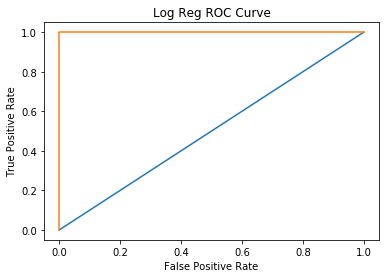

In [35]:
ly_pred_prob = logr.predict_proba(X_test)[:,1]
print('AUC-ROC score for tuned log reg model:', round(roc_auc_score(y_test, ly_pred_prob),4))
fpr, tpr, thresholds = roc_curve(y_test, ly_pred_prob)
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr, label='LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Log Reg ROC Curve')
plt.show()

In [36]:
lr_pred = logr.predict(X_test)
print(list(zip(y_test,lr_pred)))
print(confusion_matrix(y_test, lr_pred))

[(1, 1), (0, 0), (0, 0), (0, 0), (1, 1), (0, 0), (0, 1), (1, 1), (0, 0), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (1, 1), (0, 1), (0, 0), (1, 1), (1, 1), (0, 0), (0, 0), (1, 1), (0, 0), (1, 1)]
[[11  2]
 [ 0 14]]


The logistic regression model shown here seems to be the best or tied for the best among the tested models here. Based on accuracy scores, and the AUC for the ROC plot for the logistic regression model, it is a highly effective model for this analysis of predicting which DNA sequences are promoters or not, and also is a computationally straightforward method.

Model interpretability is useful to explore if interested in knowing which features (in this case nucleotide positions and identities) contribute to predictions and in which manner. For an analysis such as this one, though a model interpretability analysis may appear to suggest otherwise, it should not be expected that each nucleotide position is operating independently; adjacent nucleotides within a promoter element, as well as other possible elements, necessarily function together in interactions with DNA-binding proteins.

SHAP results are presented with a few individual predictions shown and how key nucleotide positions and identities contributed to them. Positive predictions for promoter status point to the right (closer to 1), while sequences predicted to be non-promoters point to the left. Following these, a summary plot is shown, depicting which positions and identities were most influential. After these are LIME interpretability analyses<sup>5</sup> for the same logistic regression model as that used in SHAP analysis (for one individual sample) and then for the Keras model.  

## SHAP with Scikit-Learn logistic regression model

In [37]:
shap.initjs()

explainer = shap.KernelExplainer(logr.predict_proba, X_train)

shap_values = explainer.shap_values(X_train)

100%|██████████| 79/79 [02:38<00:00,  1.93s/it]


In [38]:
shap.force_plot(explainer.expected_value[0], shap_values[1][0,:], X_test.iloc[0,:])

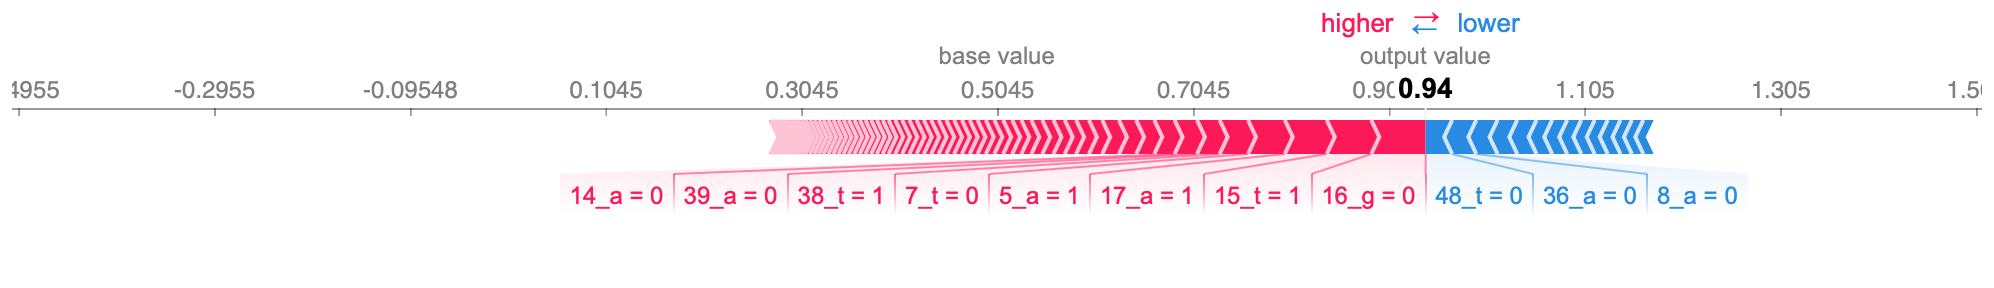

In [39]:
shap.force_plot(explainer.expected_value[0], shap_values[1][13,:], X_test.iloc[13,:])

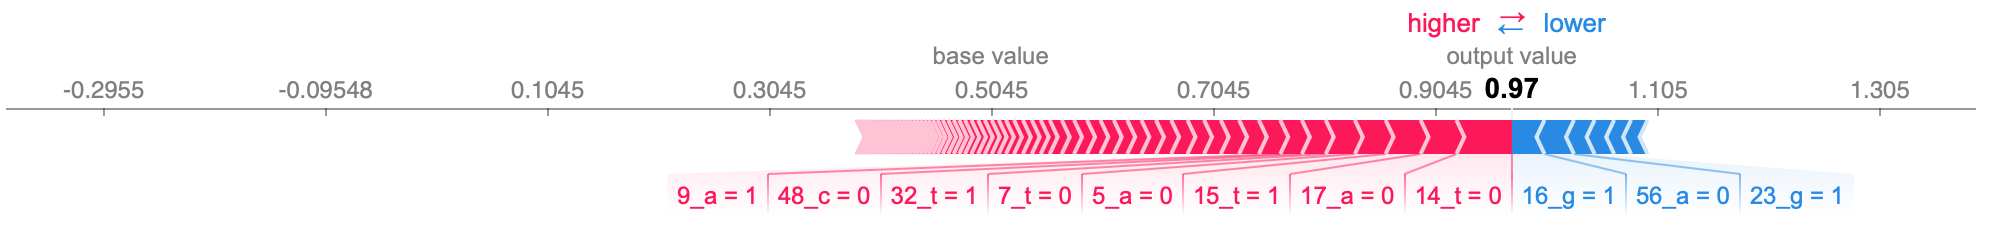

In [40]:
shap.force_plot(explainer.expected_value[0], shap_values[1][3,:], X_test.iloc[3,:])

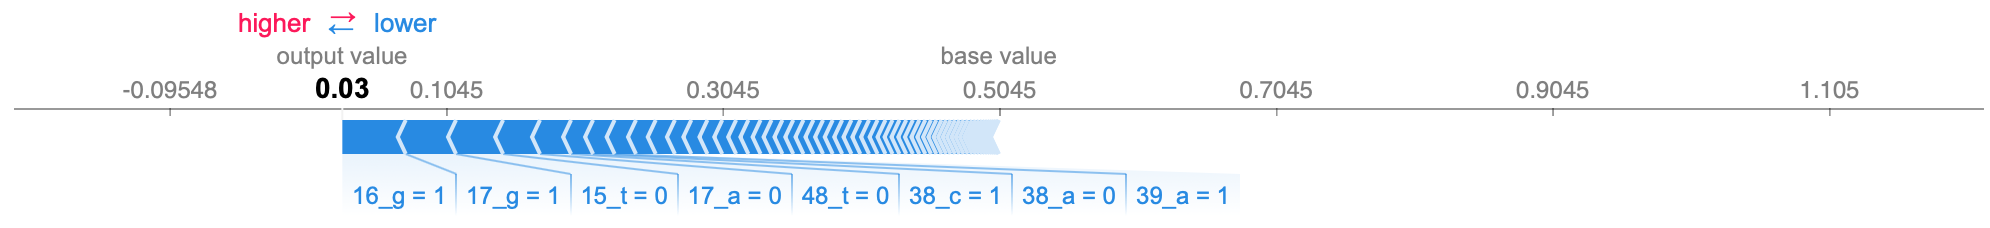

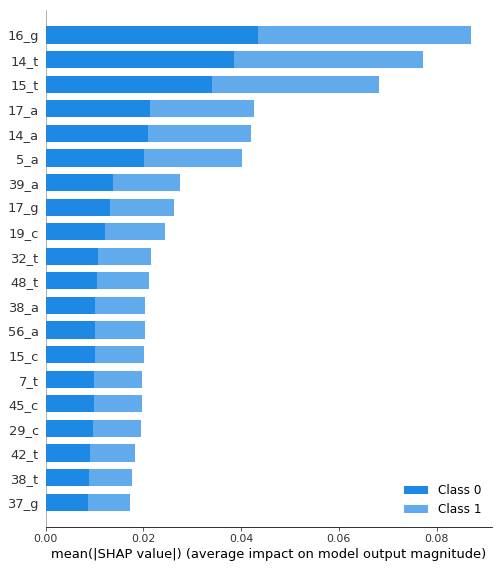

In [41]:
shap.summary_plot(shap_values, X_test)

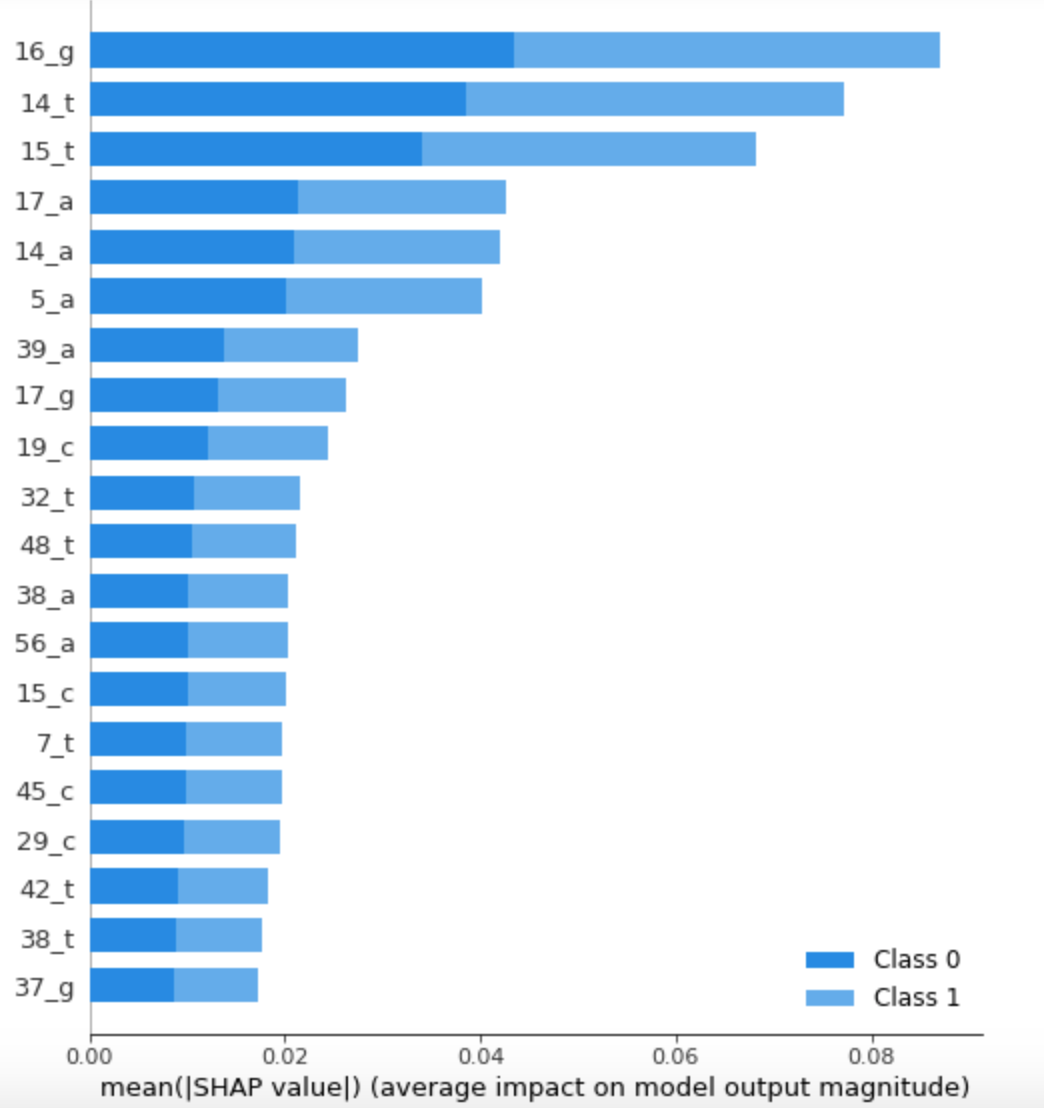

While the documentation with the SHAP package explains that it unifies multiple methods<sup>4</sup>, including the LIME model explainer, using the LIME package itself provides an expanded view of the predictive contributions of all features (228 here), which may be useful for some purposes. (Shown below are screenshots of the top results because the whole images do not appear easily when transferring the Jupyter Notebook online.) The two packages may overlap but are not identical in approach, so different prediction probabilities can arise. 

With the Keras neural network model, LIME produces an error regarding probabilities because the "predict_proba" function works differently with Keras models than with Scikit-Learn. An alternative is to use "predict_classes", but this produces an all-or-nothing result that may obscure differences between samples.

## LIME with Scikit-Learn logistic regression model

In [42]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns, 
                                                   class_names=[0,1], discretize_continuous=True)

/Users/vickimoore/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [43]:
i = 13 #sample number from X_test
exp = explainer.explain_instance(X_test.values[i], logr.predict_proba, num_features=228, top_labels=1)

In [44]:
exp.show_in_notebook(show_table=True, show_all=False)

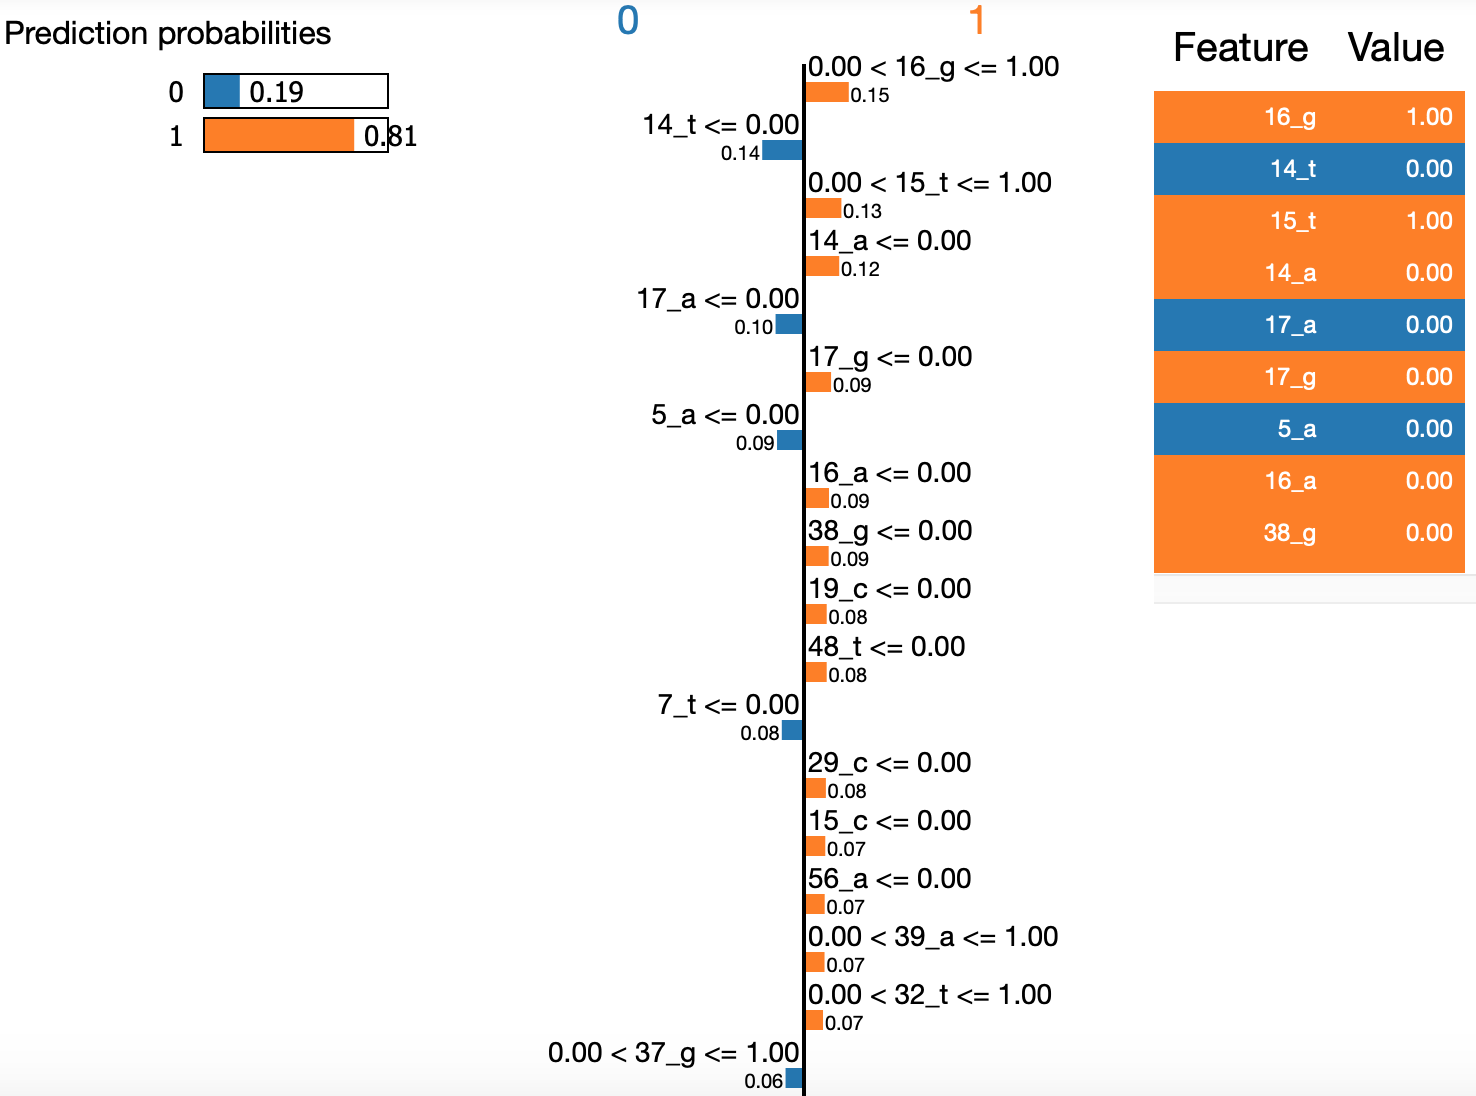

## LIME with Keras model

In [45]:
j = 13 #sample number from X_test
expnn = explainer.explain_instance(X_test.values[j], model.predict_proba, num_features=228, top_labels=1)

/Users/vickimoore/anaconda3/lib/python3.6/site-packages/lime/lime_tabular.py:296: UserWarning: 
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    
  """)


In [46]:
expnn.show_in_notebook(show_table=True, show_all=False)

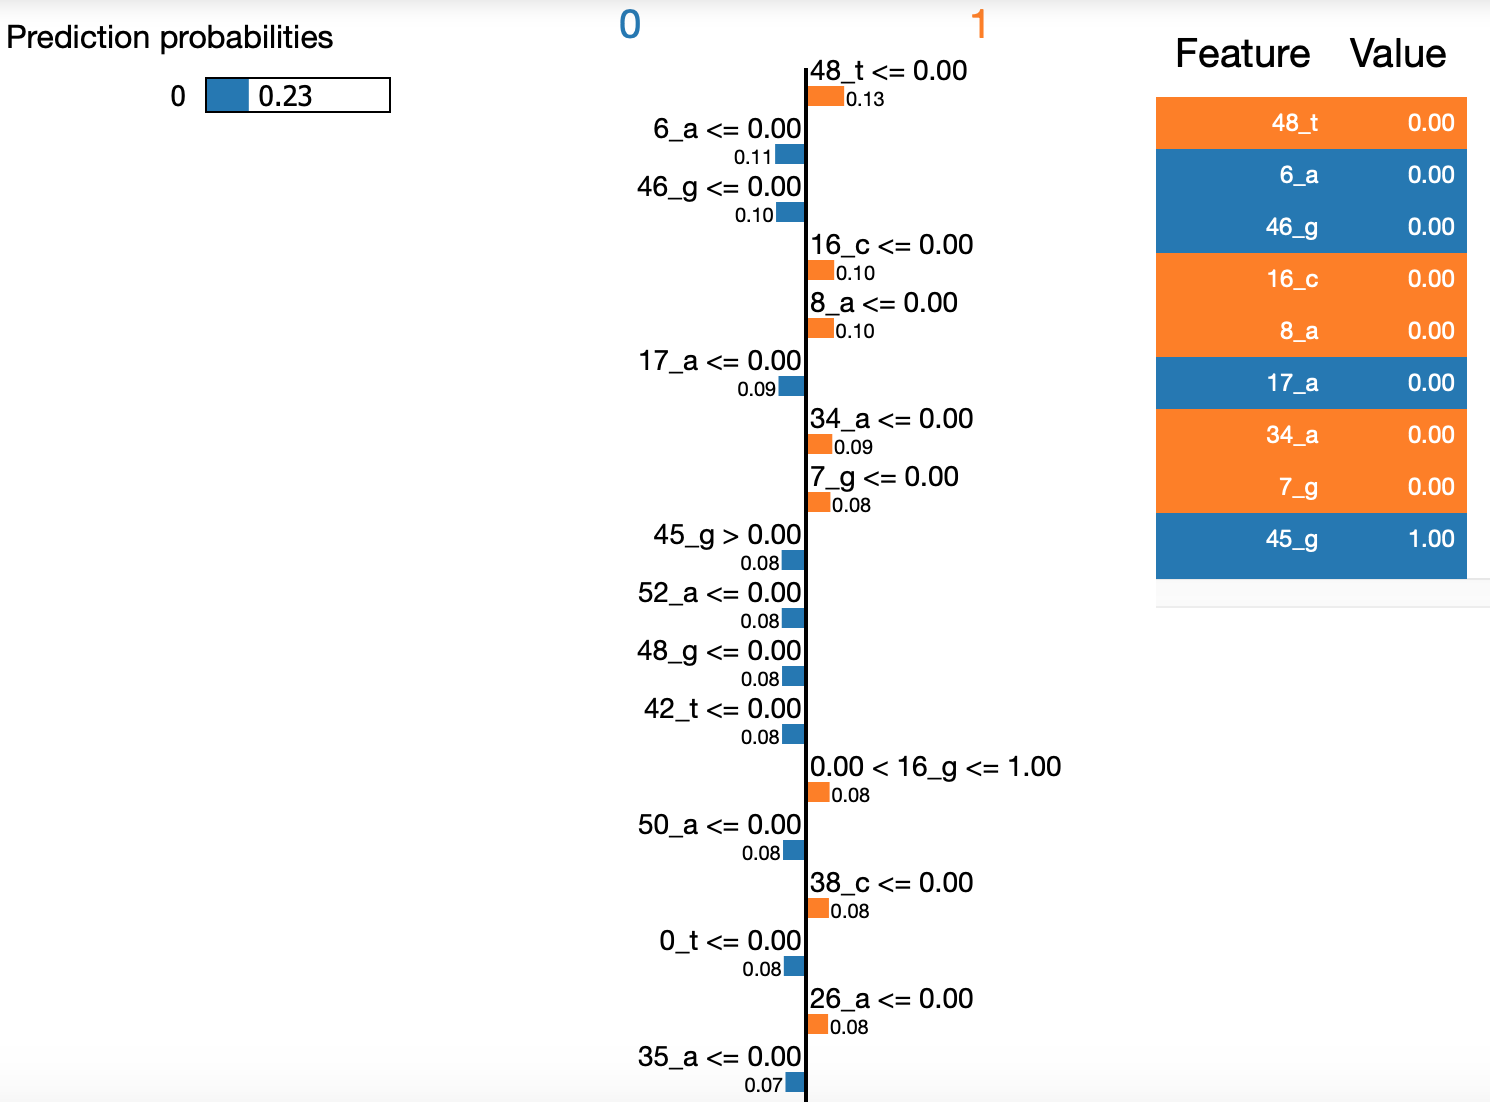

## Conclusions

This data set was amenable to high predictive accuracy (92.6% for test accuracy with multiple models) and AUC-ROC (100% for logistic regression on test data) for ascertainment of promoter status using the included DNA sequences. Model interpretability was easy to obtain for individual nucleotide positions and identities, and though analytical methods differed, two regions of sequence appeared to have positions that were important (positions 14-19 and around 37-39). Bacterial -35 and -10 promoter elements are nucleotide hexamers, but many promoters have sequences that depart from consensus sequence; it is not always ideal for RNA polymerase to remain tightly bound to a portion of DNA. For each position ranked as important here, the presence of one nucleotide and/or absence of another nucleotide was regarded as impactful for promoter status by each analysis type. Between SHAP and LIME interpretability analyses on the logistic regression model, nucleotide identity did not always show the same predictions, but the relative importances of positions were important. Also, some positions, such as position 5, ranked highly for some reason; either this is due to a low number of samples or is indicative of another DNA element that is relevant to expression.

## References

<sup>1</sup>Harley CB, Reynolds RP. Analysis of *E. coli* promoter sequences. *Nucleic Acids Res.* 1987;15:2343–2361.

<sup>2</sup>Noordewier M, Shavlik J, Harley C, Reynolds R. Molecular Biology (Promoter Gene Sequences) Data Set. https://archive.ics.uci.edu/ml/datasets/Molecular+Biology+%28Promoter+Gene+Sequences%29. Dua D, Karra Taniskidou E. UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 2017.

<sup>3</sup>Towell G, Shavlik J, Noordewier M. Refinement of Approximate Domain Theories by Knowledge-Based Artificial Neural Networks. *Proceedings of the Eighth National Conference on Artificial Intelligence (AAAI-90)*.  1990;861-866.

<sup>4</sup>Lundberg S. Shap. https://github.com/slundberg/shap.

<sup>5</sup>Ribeiro MT. Lime: Explaining the predictions of any machine learning classifier. https://github.com/marcotcr/lime. 